# Комплексный анализ и построение модели

In [1]:
# --- Часть 1: Импорты, настройка и загрузка данных ---

import sys
import os
from pathlib import Path

# --- Настройка путей ---
PROJECT_ROOT = Path(os.getcwd()).resolve()
if PROJECT_ROOT.name == 'notebooks':
    PROJECT_ROOT = PROJECT_ROOT.parent
SRC_DIR = PROJECT_ROOT / 'src'
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

# --- Основные библиотеки ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import joblib
from scipy.stats import randint, uniform

# --- Scikit-learn ---
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# --- Модели ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# --- Настройки ---
pd.options.display.max_columns = 100
sns.set_style("whitegrid")
from sklearn import set_config
set_config(display='diagram')

print(f"Project Root: {PROJECT_ROOT}")
print("✅ Импорты завершены.")

# --- Загрузка данных ---
train_path = PROJECT_ROOT / 'heart_train.csv'
test_path = PROJECT_ROOT / 'heart_test.csv'

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Удаляем возможные индексные колонки
for df in [df_train, df_test]:
    cols_to_drop = [c for c in df.columns if 'unnamed' in c.lower()]
    if cols_to_drop:
        df.drop(columns=cols_to_drop, inplace=True)

TARGET = 'Heart Attack Risk (Binary)'
X = df_train.drop(columns=[TARGET])
y = df_train[TARGET]

print("\nДанные загружены. Форма X:", X.shape)
print("Пропуски в трейне:", df_train.isnull().sum().sum())


Project Root: /Users/apple/Desktop/Cursor/fast_api_ai
✅ Импорты завершены.

Данные загружены. Форма X: (8685, 26)
Пропуски в трейне: 2187


# --- Часть 2: Исследовательский анализ данных (EDA) ---


Соотношение классов:
0 (Низкий риск): 65.31%
1 (Высокий риск): 34.69%


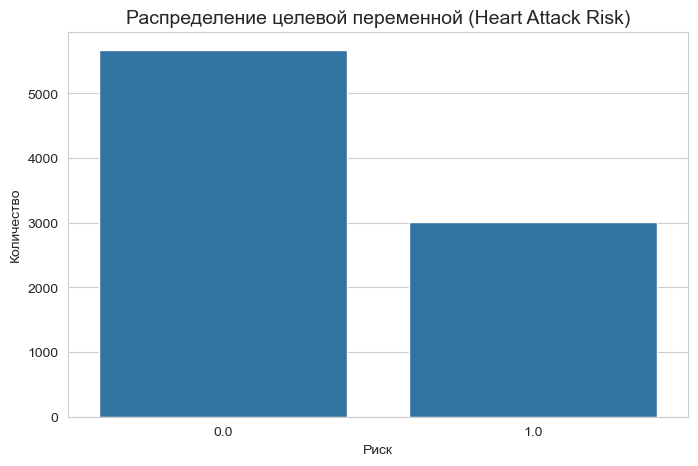

In [2]:
# --- 2.1. Анализ целевой переменной ---
plt.figure(figsize=(8, 5))
sns.countplot(x=y)
plt.title('Распределение целевой переменной (Heart Attack Risk)', fontsize=14)
plt.ylabel('Количество')
plt.xlabel('Риск')
risk_counts = y.value_counts(normalize=True) * 100
print(f"Соотношение классов:\n0 (Низкий риск): {risk_counts[0]:.2f}%\n1 (Высокий риск): {risk_counts[1]:.2f}%")
plt.show()


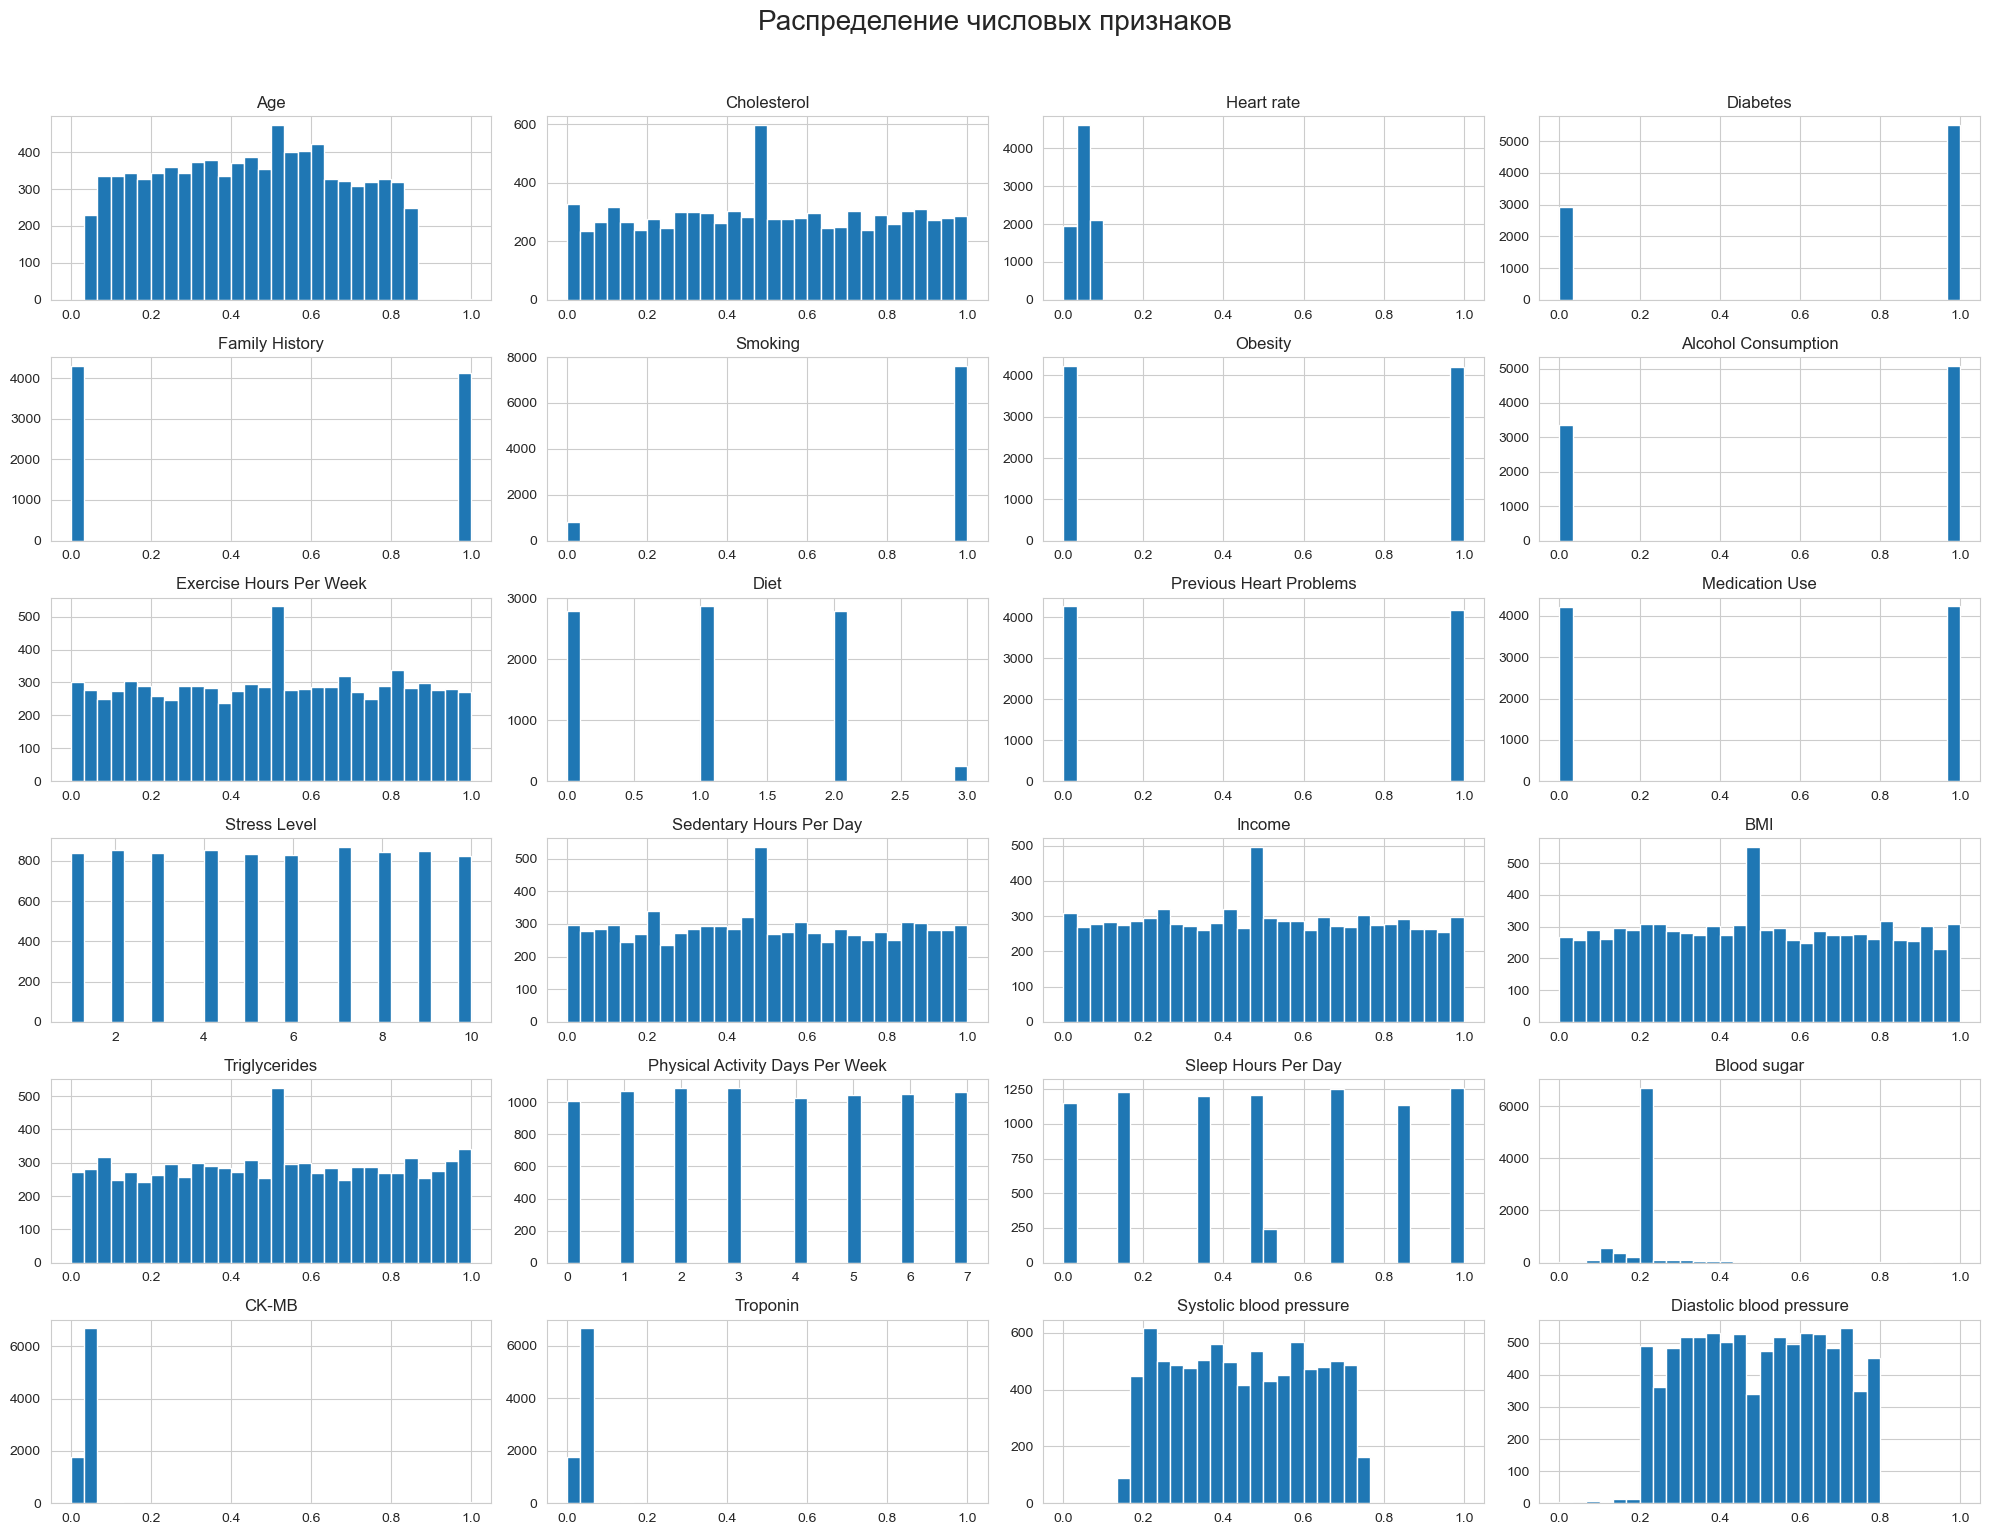

In [3]:
# --- 2.2. Анализ числовых признаков ---
numeric_cols = X.select_dtypes(include=np.number).columns.drop('id', errors='ignore')

df_train[numeric_cols].hist(bins=30, figsize=(20, 15), layout=(-1, 4))
plt.suptitle('Распределение числовых признаков', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()


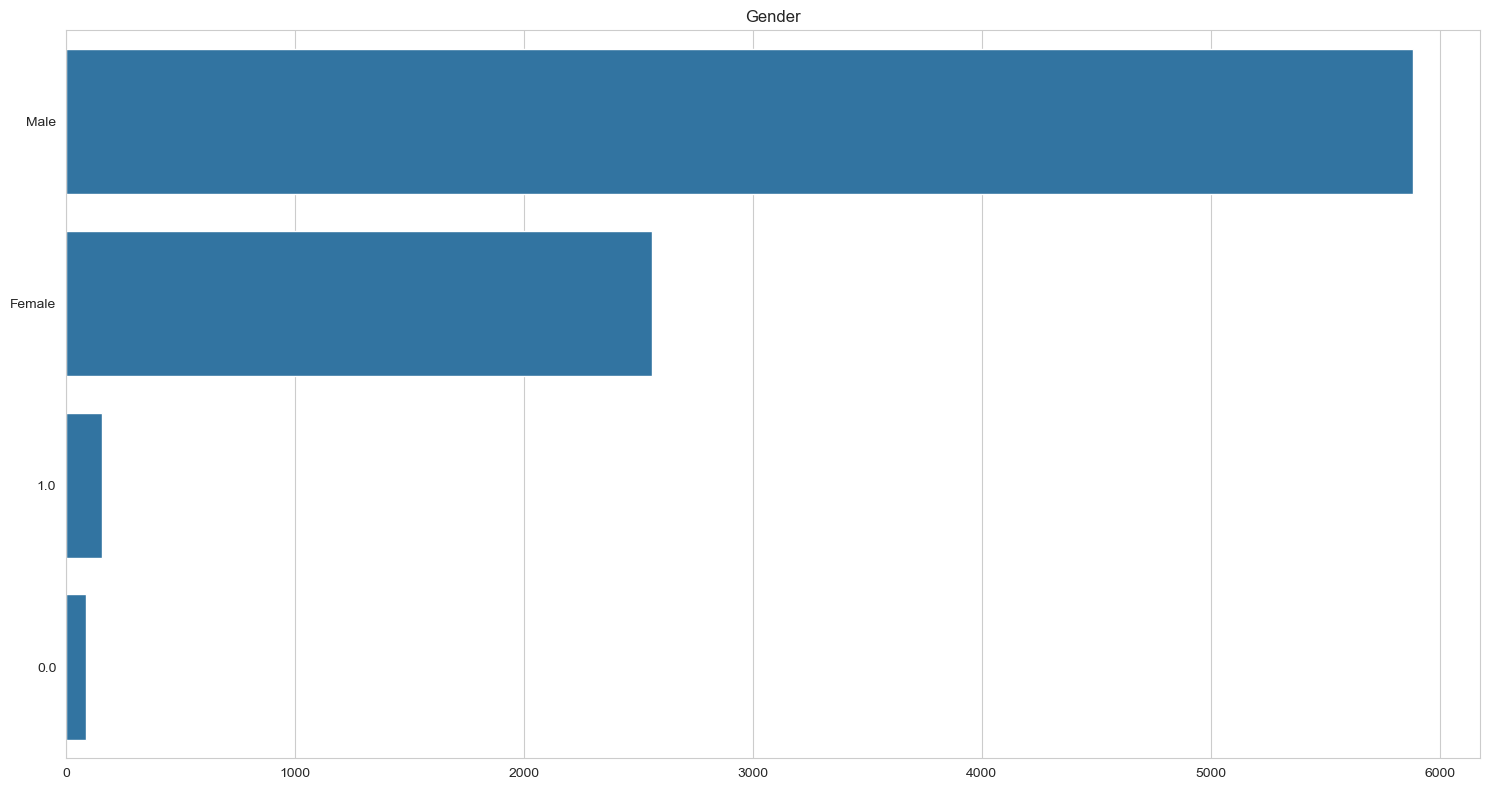

In [4]:
# --- 2.3. Анализ категориальных признаков ---
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

plt.figure(figsize=(15, 8))
for i, col in enumerate(categorical_cols):
    plt.subplot(1, len(categorical_cols), i+1)
    sns.countplot(y=df_train[col], order = df_train[col].value_counts().index)
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.show()


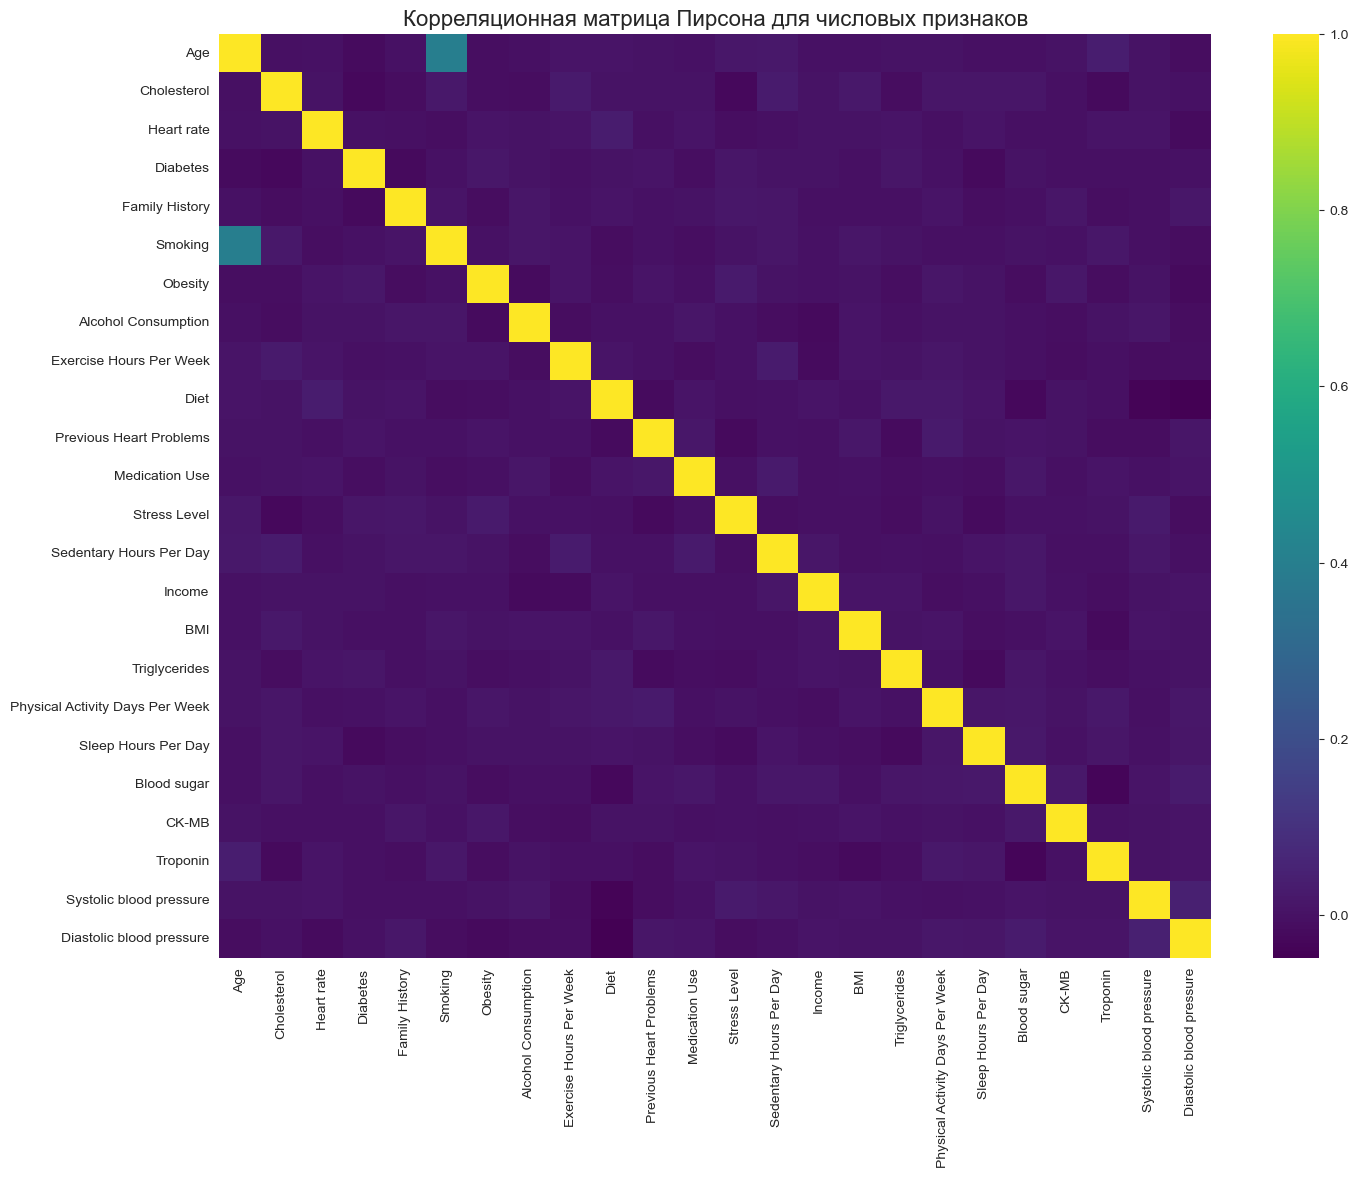

In [5]:
# --- 2.4. Корреляция Пирсона (только для числовых признаков) ---
plt.figure(figsize=(16, 12))
corr_matrix = df_train[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=False, cmap='viridis')
plt.title('Корреляционная матрица Пирсона для числовых признаков', fontsize=16)
plt.show()


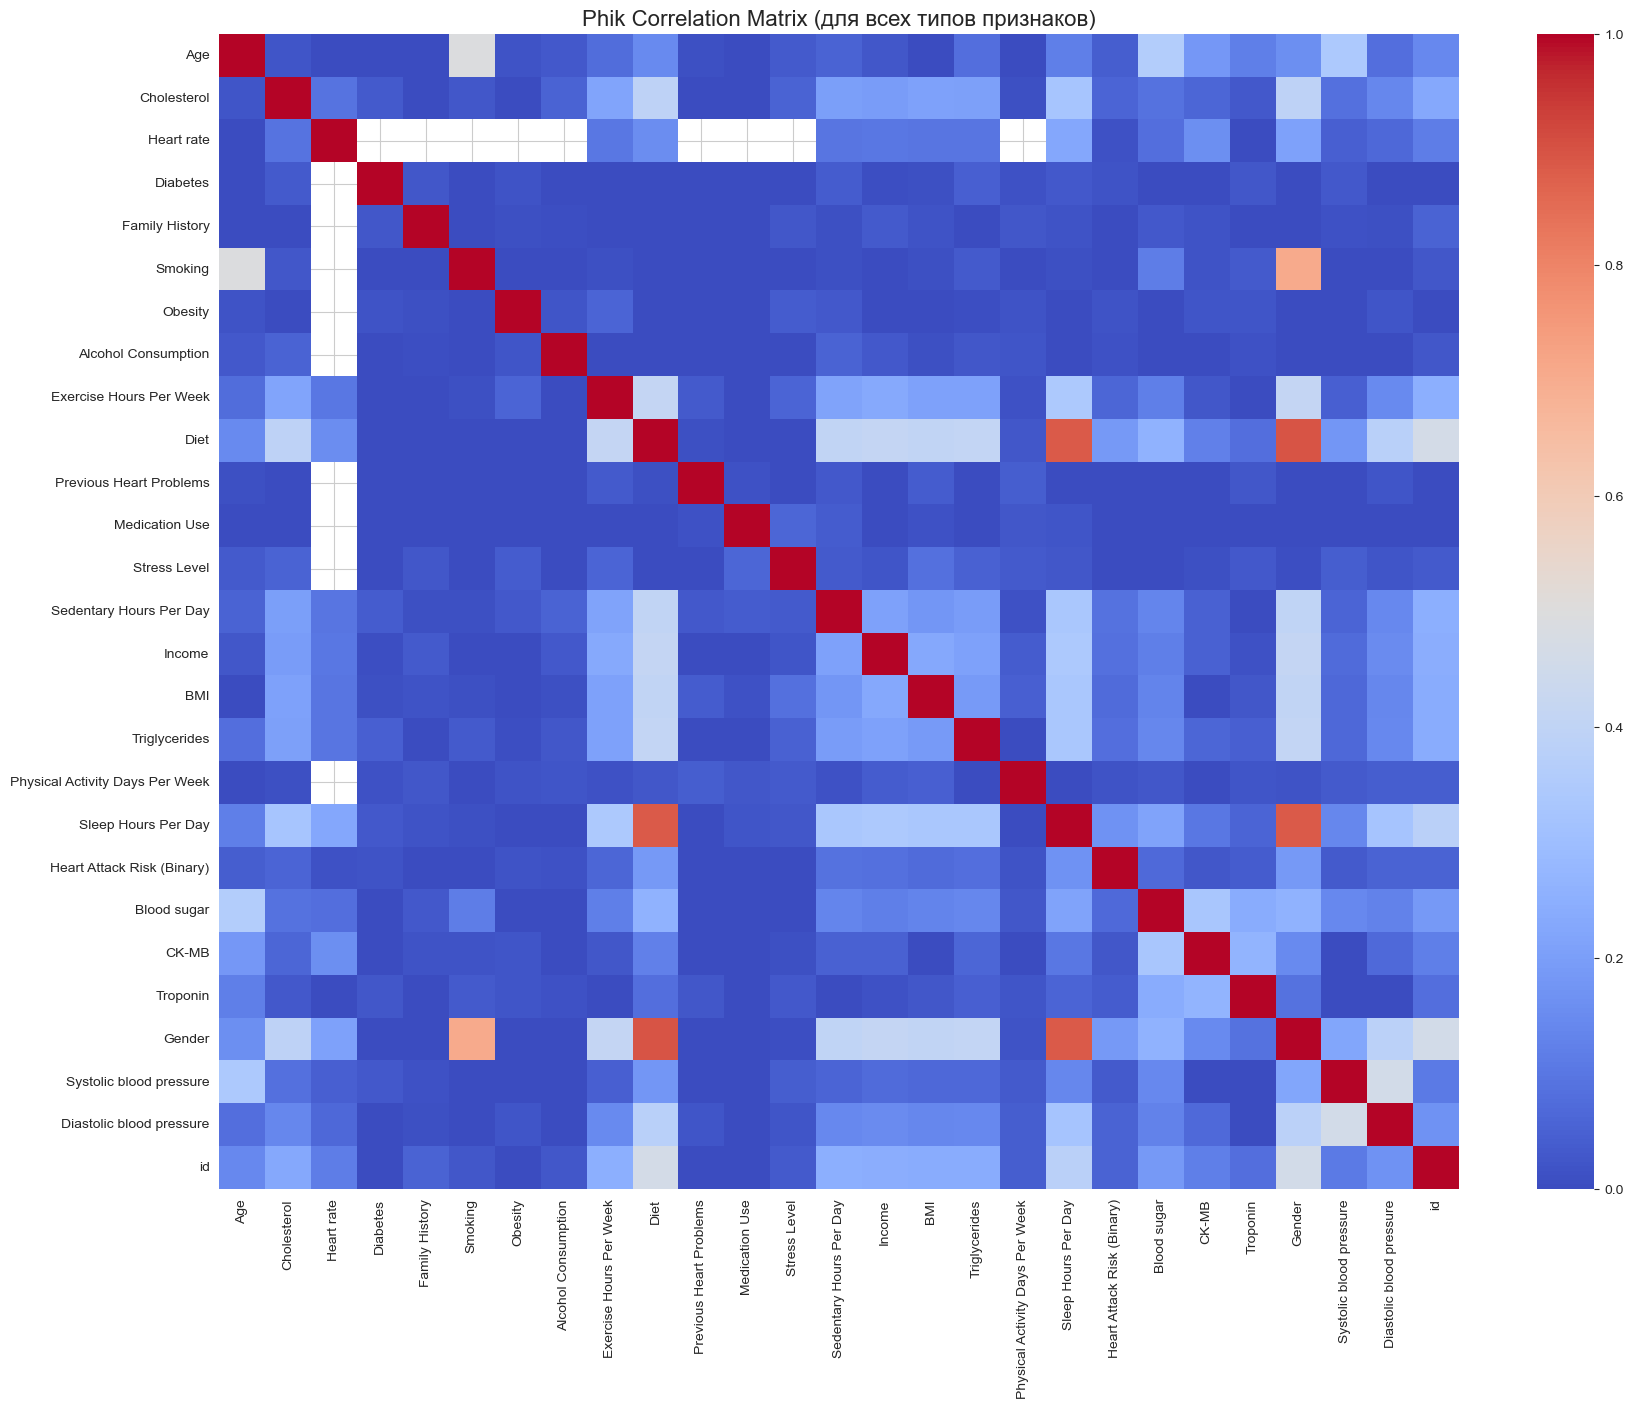


Phik Correlation with Target:
Heart Attack Risk (Binary)    1.000000
Diet                          0.186541
Gender                        0.184662
Sleep Hours Per Day           0.164119
Sedentary Hours Per Day       0.087030
Income                        0.083411
Triglycerides                 0.081883
BMI                           0.071483
Blood sugar                   0.067118
Exercise Hours Per Week       0.062494
Cholesterol                   0.057544
id                            0.054342
Diastolic blood pressure      0.053272
Age                           0.041341
Troponin                      0.035461
Name: Heart Attack Risk (Binary), dtype: float64


In [6]:
# --- 2.5. Корреляция Phik (для всех типов признаков) ---
# Определяем числовые колонки для phik. Остальные будут обработаны как категориальные автоматически.
numeric_cols_for_phik = X.select_dtypes(include=np.number).columns.tolist()

phik_matrix = df_train.phik_matrix(interval_cols=numeric_cols_for_phik)

plt.figure(figsize=(20, 15))
sns.heatmap(phik_matrix, annot=False, cmap='coolwarm')
plt.title('Phik Correlation Matrix (для всех типов признаков)', fontsize=16)
plt.show()

# Корреляция с таргетом
phik_target = phik_matrix[TARGET].sort_values(ascending=False)
print("\nPhik Correlation with Target:")
print(phik_target.head(15))


# --- Часть 3: Пайплайн предобработки ---


In [7]:
# Определяем типы колонок для ColumnTransformer

# Для OHE - признаки с низкой кардинальностью (<= 3 уникальных значения) и номинативные
ohe_cols = [col for col in X.select_dtypes(include=['object', 'category']).columns if X[col].nunique() <= 3]
ohe_cols.append('Gender') # Добавим Gender, т.к. это номинативный признак

# Для Ordinal - категориальные с > 3 значениями (предполагаем некий порядок, для древовидных моделей это ок)
ordinal_cols = [col for col in X.select_dtypes(include=['object', 'category']).columns if X[col].nunique() > 3]
ordinal_cols.append('Diet') # Diet - явно порядковый

# Числовые
numeric_cols = X.select_dtypes(include=np.number).columns.drop('id', errors='ignore').tolist()

# Убираем пересечения, чтобы признаки не дублировались
ohe_cols = list(set(ohe_cols) - set(ordinal_cols))
numeric_cols = list(set(numeric_cols) - set(ohe_cols) - set(ordinal_cols))

print(f"OneHotEncoder columns ({len(ohe_cols)}): {ohe_cols}")
print(f"OrdinalEncoder columns ({len(ordinal_cols)}): {ordinal_cols}")
print(f"NumericScaler columns ({len(numeric_cols)}): {numeric_cols}")

# --- Создаем трансформеры ---
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

ohe_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# --- Собираем все в ColumnTransformer ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('ohe', ohe_transformer, ohe_cols),
        ('ord', ordinal_transformer, ordinal_cols)
    ],
    remainder='drop' # Игнорируем колонки, не попавшие в списки (например, 'id')
)

print("\nПайплайн предобработки готов.")
preprocessor


OneHotEncoder columns (0): []
OrdinalEncoder columns (2): ['Gender', 'Diet']
NumericScaler columns (23): ['Stress Level', 'Medication Use', 'Obesity', 'Physical Activity Days Per Week', 'BMI', 'Sleep Hours Per Day', 'Diabetes', 'Cholesterol', 'Sedentary Hours Per Day', 'CK-MB', 'Troponin', 'Triglycerides', 'Heart rate', 'Income', 'Age', 'Previous Heart Problems', 'Alcohol Consumption', 'Exercise Hours Per Week', 'Blood sugar', 'Family History', 'Smoking', 'Systolic blood pressure', 'Diastolic blood pressure']

Пайплайн предобработки готов.


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Stress Level', 'Medication Use', 'Obesity',
                                  'Physical Activity Days Per Week', 'BMI',
                                  'Sleep Hours Per Day', 'Diabetes',
                                  'Cholesterol', 'Sedentary Hours Per Day',
                                  'CK-MB', 'Troponin', 'Triglycerides',
                                  'Heart rate', 'Income', 'Age',
                                  'Previous Heart...
                                  'Diastolic blood pressure']),
                                ('ohe',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'))]),
                                 []),
                                ('ord',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['Gender', 'Diet'])])

# --- Часть 4: Поиск лучшей модели с RandomizedSearchCV ---


In [8]:
# Создаем пайплайн, который включает препроцессор и модель-плейсхолдер
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression())])

# Определяем сетку поиска
param_dist = [
    # 1. Logistic Regression
    {
        'classifier': [LogisticRegression(solver='liblinear', random_state=42)],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__C': uniform(0.1, 10),
    },
    # 2. Random Forest
    {
        'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators': randint(100, 500),
        'classifier__max_depth': [10, 20, 30, None],
        'classifier__min_samples_leaf': randint(1, 5)
    },
    # 3. Gradient Boosting
    {
        'classifier': [GradientBoostingClassifier(random_state=42)],
        'classifier__n_estimators': randint(100, 500),
        'classifier__learning_rate': uniform(0.01, 0.2),
        'classifier__max_depth': randint(3, 8)
    },
    # 4. XGBoost
    {
        'classifier': [XGBClassifier(random_state=42, eval_metric='logloss')],
        'classifier__n_estimators': randint(100, 500),
        'classifier__learning_rate': uniform(0.01, 0.2),
        'classifier__max_depth': randint(3, 8),
        'classifier__subsample': uniform(0.7, 0.3)
    },
    # 5. CatBoost
    {
        'classifier': [CatBoostClassifier(random_state=42, verbose=0)],
        'classifier__n_estimators': randint(200, 800),
        'classifier__learning_rate': uniform(0.01, 0.1),
        'classifier__depth': randint(4, 8),
        'classifier__l2_leaf_reg': uniform(1, 10)
    }
]

# Настраиваем RandomizedSearchCV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,  # Увеличим кол-во итераций для более тщательного поиска
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=3
)

print("Starting Randomized Search...")
random_search.fit(X, y)

print(f"\nBest Score (ROC-AUC): {random_search.best_score_:.4f}")
print("Best Parameters:")
print(random_search.best_params_)


Starting Randomized Search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 3/3] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), classifier__learning_rate=0.20014286128198325, classifier__max_depth=5, classifier__n_estimators=171, cl

# --- Часть 5: Сохранение и проверка лучшего пайплайна ---


In [9]:
best_pipeline = random_search.best_estimator_
artifacts_dir = PROJECT_ROOT / 'artifacts'
artifacts_dir.mkdir(exist_ok=True)
pipeline_path = artifacts_dir / 'best_pipeline.pkl'

joblib.dump(best_pipeline, pipeline_path)
print(f"✅ Best pipeline saved to: {pipeline_path}")

# --- Проверка: загрузка и предсказание на тестовых данных ---
loaded_pipeline = joblib.load(pipeline_path)
test_predictions = loaded_pipeline.predict_proba(df_test)[:, 1]

# --- Создание файла для сабмита ---
submission_df = pd.DataFrame({'id': df_test['id'], 'prediction': test_predictions})
submission_path = PROJECT_ROOT / 'submission_advanced.csv'
submission_df.to_csv(submission_path, index=False)

print(f"\n✅ Submission file saved to: {submission_path}")
print("\nПример предсказаний:")
submission_df.head()


✅ Best pipeline saved to: /Users/apple/Desktop/Cursor/fast_api_ai/artifacts/best_pipeline.pkl

✅ Submission file saved to: /Users/apple/Desktop/Cursor/fast_api_ai/submission_advanced.csv

Пример предсказаний:


,id,prediction
0,7746,0.228366
1,4202,0.348333
2,6632,0.266360
3,4639,0.091105
4,4825,0.279379
